# GNN Link Prediction — Model Evaluation

Evaluation of the knowledge-graph GNN for **(Pralsetinib, inhibits, Protein)** link prediction with a **train/test split** on known off-target edges. Metrics and figures are suitable for reporting (e.g. poster).

In [1]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Project root: assume notebook is in notebooks/; if cwd is project root, use it
_cwd = Path(".").resolve()
if (_cwd / "data" / "kg_nodes_final.csv").exists():
    PROJECT_ROOT = _cwd
else:
    PROJECT_ROOT = _cwd.parent
SCRIPT_DIR = PROJECT_ROOT / "scripts" / "modeling" / "gnn"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPT_DIR))

from kg_gnn_data import (
    get_positive_and_candidate_tails,
    get_protein_outcome_pairs,
    load_kg_graph,
    negative_sampling,
)
from kg_gnn_model import GCNLinkPredictor

# Poster-friendly style
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11
sns.set_theme(style="whitegrid", palette="husl")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

c:\Users\suchi\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data and train/test split

Load the KG and split known **(Pralsetinib, inhibits, Protein)** edges into train (80%) and test (20%) for evaluation.

In [2]:
DATA_DIR = PROJECT_ROOT / "data"
nodes_path = DATA_DIR / "kg_nodes_final.csv"
edges_path = DATA_DIR / "kg_edges_final.csv"
assert nodes_path.exists() and edges_path.exists(), "Run from repo with data/kg_nodes_final.csv and data/kg_edges_final.csv"

data, id_to_idx = load_kg_graph(nodes_path, edges_path)
idx_to_id = {v: k for k, v in id_to_idx.items()}

positive_tails, candidate_tails, drug_idx = get_positive_and_candidate_tails(
    edges_path, id_to_idx, nodes_path
)
n_pos = len(positive_tails)
assert n_pos > 0, "No positive (Pralsetinib, inhibits, protein) edges found."

# Train/test split: hold out 20% + 1 extra protein edge
test_frac = 0.2
n_test = max(1, int(round(test_frac * n_pos))) + 1
indices = list(range(n_pos))
random.shuffle(indices)
train_pos = [positive_tails[i] for i in indices[n_test:]]
test_pos = [positive_tails[i] for i in indices[:n_test]]

print(f"Known positives: {n_pos}")
print(f"Train: {len(train_pos)}  |  Test (held-out): {len(test_pos)}")
print(f"Candidate proteins (ranking pool): {len(candidate_tails)}")

Known positives: 13
Train: 9  |  Test (held-out): 4
Candidate proteins (ranking pool): 516


## 2. Train GNN on training set only

Negative sampling uses only non-positive candidates. Outcome (protein–outcome) auxiliary task is optional.

In [3]:
# Negatives for training (exclude all known positives so test set is never used in loss)
neg_pairs = negative_sampling(
    drug_idx, train_pos, candidate_tails,
    num_negatives_per_positive=5, seed=SEED,
)
neg_tail_indices = [p[1] for p in neg_pairs]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_gpu = data.to(device)
in_channels = data_gpu.x.size(1)
model = GCNLinkPredictor(
    in_channels=in_channels, hidden_channels=64, out_channels=32,
    num_layers=2, dropout=0.5,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

pos_tensor = torch.tensor(train_pos, dtype=torch.long, device=device)
neg_tensor = torch.tensor(neg_tail_indices, dtype=torch.long, device=device)

epochs = 200
train_losses = []
total_losses = []

model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    h = model(data_gpu)

    loss = model.loss_batch(h, drug_idx, pos_tensor, neg_tensor)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    total_losses.append(loss.item())

    if (epoch + 1) % 50 == 0 or epoch == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, loss = {loss.item():.4f}")

print("Training done.")

Epoch 1/200, loss = 0.6983
Epoch 50/200, loss = 0.0595
Epoch 100/200, loss = 0.0461
Epoch 150/200, loss = 0.0723
Epoch 200/200, loss = 0.0575
Training done.


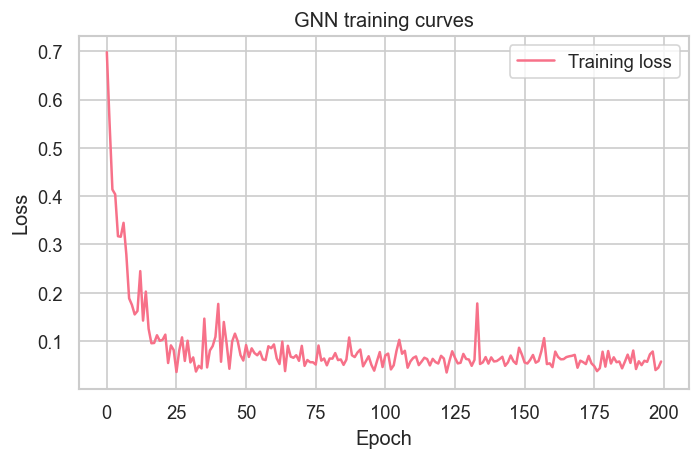

In [4]:
# GNN training curves
plt.figure(figsize=(6, 4))
plt.plot(total_losses, label="Training loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN training curves")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Evaluate on held-out test set

Score all candidate proteins and compute where held-out positives rank. Then compute **Recall@k**, **MRR**, and rank statistics.

In [5]:
model.eval()
with torch.no_grad():
    h = model(data_gpu)
    cand_tensor = torch.tensor(candidate_tails, dtype=torch.long, device=device)
    scores = model.predict_link(h, drug_idx, cand_tensor)
    scores_np = scores.cpu().numpy()

# Rank order (descending score)
order = scores_np.argsort()[::-1]  # indices into candidate_tails
test_set = set(test_pos)

# For each test positive, get its 1-based rank (or None if not in candidates)
pos_to_rank = {}
for rank_1based, idx in enumerate(order, start=1):
    tail_idx = candidate_tails[idx]
    if tail_idx in test_set and tail_idx not in pos_to_rank:
        pos_to_rank[tail_idx] = rank_1based
    if len(pos_to_rank) == len(test_set):
        break

# Ranks of test positives (use n_candidates+1 for unranked)
n_candidates = len(candidate_tails)
ranks = [pos_to_rank.get(p, n_candidates + 1) for p in test_pos]

# Metrics (Recall@k only up to k=20)
k_list = [5, 10, 20, 50]
recall_at_k = {}
for k in k_list:
    recall_at_k[k] = sum(1 for r in ranks if r <= k) / len(test_pos) if test_pos else 0.0

# MRR: mean of 1/rank
mrr = np.mean([1.0 / r for r in ranks]) if ranks else 0.0
mean_rank = np.mean(ranks)
median_rank = np.median(ranks)

# Store for tables/plots
metrics_summary = {
    "Recall@5": recall_at_k[5],
    "Recall@10": recall_at_k[10],
    "Recall@20": recall_at_k[20],
    "Recall@50": recall_at_k[50],
    "Mean rank": mean_rank,
    "Median rank": median_rank,
}
print("Test set metrics:")
for name, val in metrics_summary.items():
    if "Recall" in name or "MRR" in name:
        print(f"  {name}: {val:.3f}")
    else:
        print(f"  {name}: {val:.1f}")

Test set metrics:
  Recall@5: 0.250
  Recall@10: 0.750
  Recall@20: 1.000
  Recall@50: 1.000
  Mean rank: 8.8
  Median rank: 8.0


## 5. Visualizations

Embedding tensor shape: torch.Size([1081, 32])
Embedding norms: mean = 10.944, std = 10.678


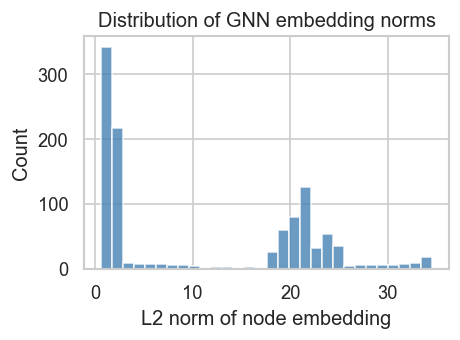

In [6]:
# 3a. Inspect GNN node embeddings
model.eval()
with torch.no_grad():
    h = model(data_gpu)  # [num_nodes, embed_dim]

print("Embedding tensor shape:", h.shape)

h_cpu = h.cpu().numpy()
emb_norms = np.linalg.norm(h_cpu, axis=1)

print("Embedding norms: mean = {:.3f}, std = {:.3f}".format(
    emb_norms.mean(), emb_norms.std()
))

plt.figure(figsize=(4, 3))
plt.hist(emb_norms, bins=30, color="steelblue", alpha=0.8)
plt.xlabel("L2 norm of node embedding")
plt.ylabel("Count")
plt.title("Distribution of GNN embedding norms")
plt.tight_layout()
plt.show()

Positive scores: mean = 0.932, std = 0.028
Negative scores: mean = 0.012, std = 0.094


C:\Users\suchi\AppData\Local\Temp\ipykernel_17488\1540859992.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


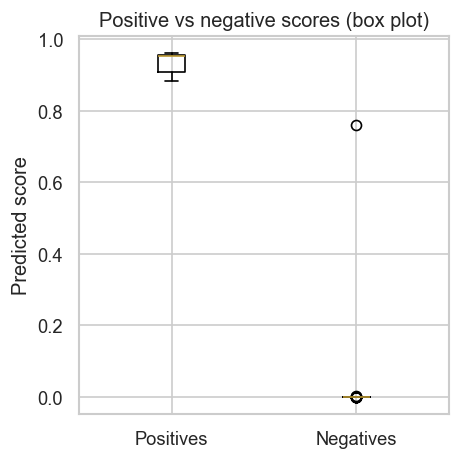

In [7]:
# 3b. Positive vs negative score distributions for (Pralsetinib, protein)
model.eval()
with torch.no_grad():
    # All known positives (train + test)
    all_pos_tails = torch.tensor(positive_tails, dtype=torch.long, device=device)
    pos_scores = model.predict_link(h, drug_idx, all_pos_tails).cpu().numpy()

    # Sample negatives from candidate_tails that are not positives
    pos_set = set(positive_tails)
    neg_pool = [t for t in candidate_tails if t not in pos_set]
    neg_sample = random.sample(neg_pool, min(len(neg_pool), len(positive_tails) * 5))
    neg_tails_t = torch.tensor(neg_sample, dtype=torch.long, device=device)
    neg_scores = model.predict_link(h, drug_idx, neg_tails_t).cpu().numpy()

print("Positive scores: mean = {:.3f}, std = {:.3f}".format(pos_scores.mean(), pos_scores.std()))
print("Negative scores: mean = {:.3f}, std = {:.3f}".format(neg_scores.mean(), neg_scores.std()))

plt.figure(figsize=(4, 4))
plt.boxplot(
    [pos_scores, neg_scores],
    labels=["Positives", "Negatives"],
    showfliers=True,
)
plt.ylabel("Predicted score")
plt.title("Positive vs negative scores (box plot)")
plt.tight_layout()
plt.show()

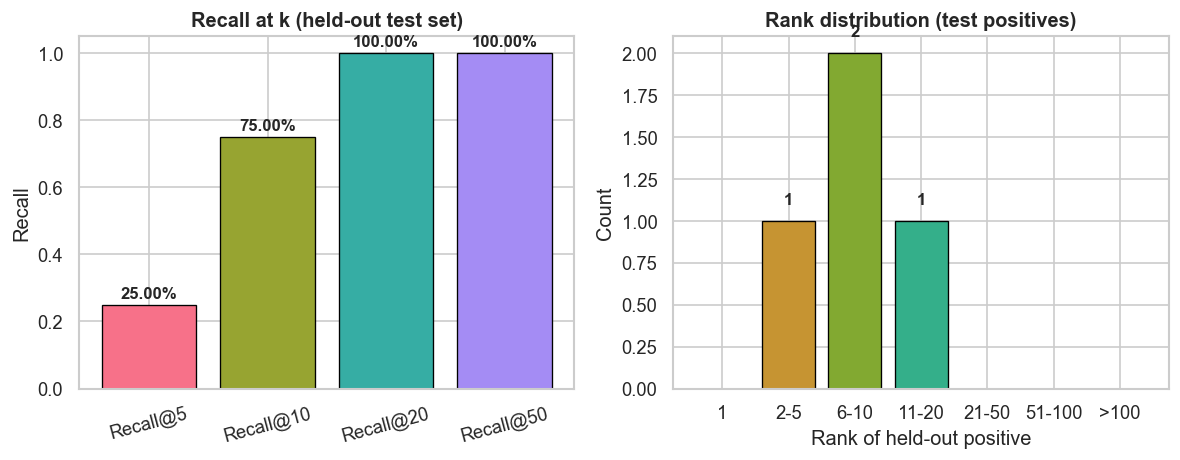

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Recall@k bar chart
ax1 = axes[0]
x = [f"Recall@{k}" for k in k_list]
y = [recall_at_k[k] for k in k_list]
bars = ax1.bar(x, y, color=sns.color_palette("husl", len(k_list)), edgecolor="black", linewidth=0.8)
ax1.set_ylabel("Recall", fontsize=12)
ax1.set_ylim(0, 1.05)
ax1.set_title("Recall at k (held-out test set)", fontsize=12, fontweight="bold")
for b, v in zip(bars, y):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")
ax1.tick_params(axis="x", rotation=15)

# Rank distribution (test positives)
ax2 = axes[1]
def bucket_rank(r):
    if r <= 1: return 0
    if r <= 5: return 1
    if r <= 10: return 2
    if r <= 20: return 3
    if r <= 50: return 4
    if r <= 100: return 5
    return 6
rank_labels = ["1", "2-5", "6-10", "11-20", "21-50", "51-100", ">100"]
counts = [sum(1 for r in ranks if bucket_rank(r) == i) for i in range(7)]
colors = sns.color_palette("husl", len(rank_labels))
bars2 = ax2.bar(rank_labels, counts, color=colors, edgecolor="black", linewidth=0.8)
ax2.set_xlabel("Rank of held-out positive", fontsize=12)
ax2.set_ylabel("Count", fontsize=12)
ax2.set_title("Rank distribution (test positives)", fontsize=12, fontweight="bold")
for b, c in zip(bars2, counts):
    if c > 0:
        ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.1, str(c), ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

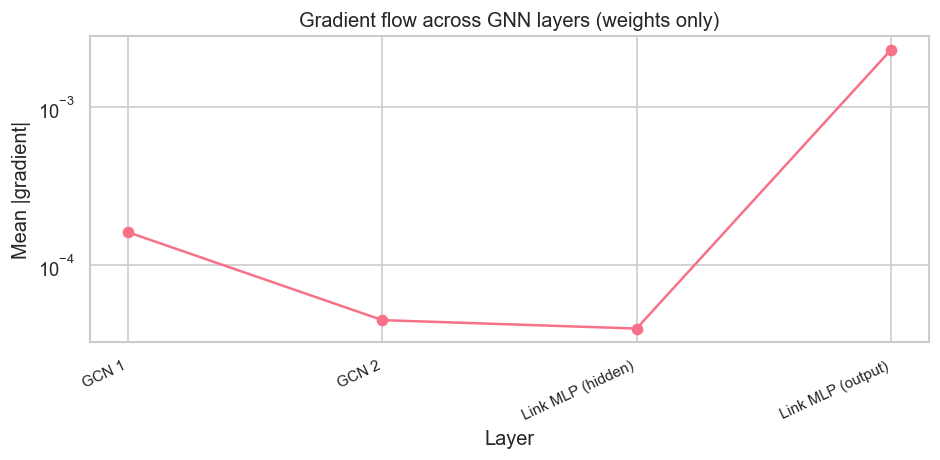

In [11]:
# 3d. Gradient flow across GNN layers (mean |grad| per weight only)

def _grad_layer_label(name):
    """Convert param name to short plot label (weights only)."""
    if "convs." in name and ".weight" in name:
        i = int(name.split(".")[1])
        return f"GCN {i + 1}"
    if "link_mlp.0.weight" in name:
        return "Link MLP (hidden)"
    if "link_mlp.3.weight" in name:
        return "Link MLP (output)"
    return name

model.train()
optimizer.zero_grad()

# Single full-batch loss, same as training
h = model(data_gpu)
loss = model.loss_batch(h, drug_idx, pos_tensor, neg_tensor)
loss.backward()

display_names = []
avg_grads = []

for name, param in model.named_parameters():
    if param.grad is not None and "weight" in name:
        display_names.append(_grad_layer_label(name))
        avg_grads.append(param.grad.detach().abs().mean().item())

plt.figure(figsize=(8, 4))
plt.plot(range(len(avg_grads)), avg_grads, marker="o")
plt.xticks(range(len(avg_grads)), display_names, rotation=25, ha="right", fontsize=9)
plt.yscale("log")
plt.xlabel("Layer")
plt.ylabel("Mean |gradient|")
plt.title("Gradient flow across GNN layers (weights only)")
plt.tight_layout()
plt.show()